In [1]:
import os
os.environ['R_HOME'] = "/scratch_tmp/users/k21066795/r_env/lib/R"
import sys
sys.path.append('/scratch_tmp/users/k21066795/conda/miloR/')

import glob
import h5py
import numpy as np
import pandas as pd
from pathlib import Path
import leidenalg
import scanpy as sc
import anndata

import seaborn as sns
import matplotlib.pyplot as plt

import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [2]:
file_path = f'/scratch_tmp/prj/cb_normalbreast/prj_NBTPhenotyping/RESULTS/adata/adata_UNI_aug_normal_4levels.h5ad'
adata_normal = sc.read_h5ad(file_path)
adata_normal

AnnData object with n_obs × n_vars = 33090 × 512
    obs: 'patch_id', 'cohort', 'wsi_id', 'source', 'leiden_0.5', 'highlight', 'size', 'alpha', 'top_samples', 'label', 'leiden_1.0', 'umap1', 'umap2', 'leiden_0.5_top_samples', 'leiden_1.0_top_samples', 'leiden_1.5', 'leiden_1.5_top_samples', 'leiden_2.0', 'leiden_2.0_top_samples'
    uns: 'cohort_colors', 'highlight_colors', 'label_colors', 'leiden_0.5', 'leiden_0.5_colors', 'leiden_0.5_sizes', 'leiden_1.0', 'leiden_1.0_colors', 'leiden_1.0_sizes', 'leiden_1.5', 'leiden_1.5_colors', 'leiden_1.5_sizes', 'leiden_2.0', 'leiden_2.0_colors', 'leiden_2.0_sizes', 'nn_15', 'paga', 'pca', 'source_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'nn_15_connectivities', 'nn_15_distances'

In [3]:
data = adata_normal.obs
leiden_columns = [col for col in data.columns if 'top_samples' not in col]

data = data.loc[:, leiden_columns]
data.columns = data.columns.str.replace('.', '', regex=False)
leiden_columns = [col for col in data.columns if col.startswith('leiden_')]
data[leiden_columns] = data[leiden_columns].apply(pd.to_numeric, errors='coerce')
data

,patch_id,cohort,wsi_id,source,leiden_05,highlight,size,alpha,label,leiden_10,umap1,umap2,leiden_15,leiden_20
patch_id,,,,,,,,,,,,,,
BRACS_1640_N_2_512_1792,BRACS_1640_N_2_512_1792,BRACS,BRACS_1640_N_2,N,3,other,5,0.1,N,0,7.993926,2.326387,0,9
BRACS_1235_N_6_1792_256,BRACS_1235_N_6_1792_256,BRACS,BRACS_1235_N_6,N,3,other,5,0.1,N,0,9.781749,1.920856,0,17
BRACS_1507_N_3_1792_3328,BRACS_1507_N_3_1792_3328,BRACS,BRACS_1507_N_3,N,3,other,5,0.1,N,0,10.651529,2.131059,0,23
BRACS_735_N_7_256_1792,BRACS_735_N_7_256_1792,BRACS,BRACS_735_N_7,N,3,other,5,0.1,N,0,8.880115,2.453269,0,9
BRACS_1507_N_10_512_1792,BRACS_1507_N_10_512_1792,BRACS,BRACS_1507_N_10,N,3,other,5,0.1,N,0,11.032583,1.855597,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22002580_FPE_1_138268_45534_11501_17876_249_86_578,22002580_FPE_1_138268_45534_11501_17876_249_86...,KHP_RRM,22002580_FPE_1,RRM,2,other,5,0.1,N,4,6.497423,-1.895395,10,10
21001337_FPE_3_17181_42172_6302_5721_33_77_578,21001337_FPE_3_17181_42172_6302_5721_33_77_578,KHP_RRM,21001337_FPE_3,RRM,0,other,5,0.1,N,2,9.000693,7.895208,5,4
21002307_FPE_2_21713_17667_22454_24188_68_66_578,21002307_FPE_2_21713_17667_22454_24188_68_66_578,KHP_RRM,21002307_FPE_2,RRM,4,other,5,0.1,N,8,8.682595,4.142338,7,12


In [4]:
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [ ]:
anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R

library(clustree)
library(ggplot2)
options(scipen = 999)
library(scales)
library(tidyr)
library(pheatmap)
# library("ggpubr")

Loading required package: ggraph
Loading required package: ggplot2
In addition: Warning messages:
1: package ‘scales’ was built under R version 4.2.3 
2: package ‘pheatmap’ was built under R version 4.2.3 


In [8]:
%%R -i data

colnames(data)

 [1] "patch_id"  "cohort"    "wsi_id"    "source"    "leiden_05" "highlight"
 [7] "size"      "alpha"     "label"     "leiden_10" "umap1"     "umap2"    
[13] "leiden_15" "leiden_20"


Scale for edge_colour is already present.
Adding another scale for edge_colour, which will replace the existing scale.


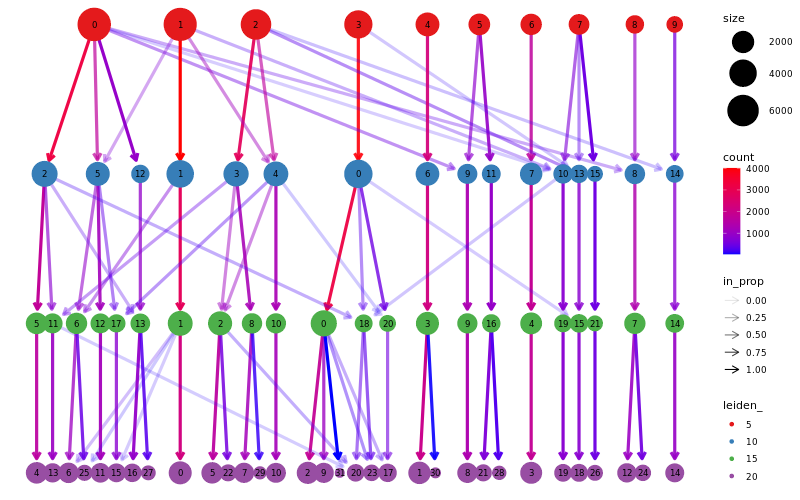

In [19]:
%%R -w 800 -h 500

data <- data.frame(
    leiden_05 = data$leiden_05,
    leiden_10 = data$leiden_10,
    leiden_15 = data$leiden_15,
    leiden_20 = data$leiden_20
)

p <- clustree(data, prefix = "leiden_") +
  scale_color_brewer(palette = "Set1") +
  scale_edge_color_continuous(low = "blue", high = "red")

ggsave("/scratch_tmp/prj/cb_normalbreast/prj_NBTPhenotyping/RESULTS/cluster_exps/clustree_4levels.pdf", plot = p, width = 8, height = 5, device = "pdf")
p